# Conformalized Early Stopping -- Anomaly Detection

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Some useful functions

In [2]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]


# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
#     # unnormalize
#     invTrans = transforms.Compose([ transforms.Normalize(mean = [0.0],
#                                                          std = [ 1/0.5]),
#                                     transforms.Normalize(mean = [ -0.5 ],
#                                                          std = [ 1.]),
#                                    ])

#     img = invTrans(img)
    # Convert tensor to numpy array
    npimg = img.cpu().numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    


def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()


In [3]:
import torch as th
import numpy as np

from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt

In [4]:
import sys, os

In [5]:
sys.path.append('../ConformalizedES')
sys.path.append('../third_party')

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
from torchvision import transforms
from torchvision import datasets

In [8]:
# Download the MNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=0.5, std=0.5)])

train_set_full = datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set_full = datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

## Customized dataloader class 
The customized dataloader class is modified from https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f.

This customized dataloader enables us to selected subset of the full MNIST data with desired labels.
Here we will take label 0 data as inliers for training and label 8 data as outliers for testing.

In [9]:
from datasetMaker import get_class_i, DatasetMaker

In [10]:
x_train_full = train_set_full.data
y_train_full = train_set_full.targets
x_test_full = test_set_full.data
y_test_full = test_set_full.targets

In [11]:
# Train set composed only of number 0
train_set = \
    DatasetMaker(
        [get_class_i(x_train_full, y_train_full, 0)]
    )

# Test set is a mixture of number 0 and 1
test_set = \
    DatasetMaker(
        [get_class_i(x_test_full, y_test_full, 0),
        get_class_i(x_test_full, y_test_full, 8),
]
    )

print('total number of available training data is: {:d}.'.format(len(train_set)))
print('total number of test data is {:d} in which {:d} are label 0 test data, {:d} are label 8 test data.'\
      .format(len(test_set), test_set.lengths[0],test_set.lengths[1]))

total number of available training data is: 5923.
total number of test data is 1954 in which 980 are label 0 test data, 974 are label 8 test data.


## Randomly plot some images

In [12]:
example_loader = th.utils.data.DataLoader(test_set, shuffle=True, batch_size=4, num_workers=0)
dataiter = iter(example_loader)
images, labels = next(dataiter)

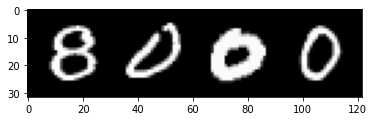

In [13]:
imshow(torchvision.utils.make_grid(images))

# Train Autoencoder

In [14]:
sys.path.append('../ConformalizedES')
sys.path.append('../third_party')

In [15]:
from method import CES_oneClass
from networks import ConvAutoencoder

In [16]:
# Define the model parameters

net = ConvAutoencoder()
lr = 0.01
n_epoch = 20
batch_size = 10

In [17]:
import torch.optim as optim

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer = optim.Adam(net.parameters(), lr=lr)

In [18]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_training_samples = 400 # Max training number: 5923
n_val_samples = 100

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [20]:
def get_train_loader(batch_size):
    return th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

train_loader = get_train_loader(batch_size)

# Use larger batch size for validation to speed up computation
val_loader = th.utils.data.DataLoader(train_set, batch_size=100, sampler=val_sampler,
                                          num_workers=num_workers)

In [21]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_oc = CES_oneClass(net, device, train_loader, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader, criterion=criterion,optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 20
learning_rate= 0.01


In [22]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc.full_train(save_dir = './models/oneClass', save_every = save_every)

ValueError: Either `preds` and `target` both should have the (same) shape (N, ...), or `target` should be (N, ...) and `preds` should be (N, C, ...).

In [ ]:
plot_loss(CES_oc.train_loss_history, CES_oc.val_loss_history)

# Select best models and compute conformal p-values

## Check the benchmark model
select_model function will choose the best model for given test point, if no test point
is given, it will output the best model selected ONLY based on validation data, which
serves as an benchmark model.

In [ ]:
# check the benchmark model
bm_loss, bm_model, loss_history = CES_oc.select_model()

In [ ]:
# Benchmark model corresponds to the one with smallest validation loss
print('Benchmark best loss is: {:.3f}'.format(bm_loss))
print('Benchmark best model is saved in:', bm_model)

# Select best models for each test point

In [ ]:
import time

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 1800
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

In [ ]:
# Pick the best model for each test point
start = time.time()
best_loss, best_model, test_val_loss_history = CES_oc.select_model(inputs)
print('selecting models takes:', time.time()-start)

In [ ]:
from inference import Conformal_PVals

model_list = CES_oc.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals = Conformal_PVals(net, device, val_loader, model_list, random_state = 2023)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

## Check the anomaly scores of inliers and outliers

In [ ]:
idx_in = np.where(labels==0)[0]
idx_out = np.where(labels==1)[0]
inputs_in = inputs[idx_in]
inputs_out = inputs[idx_out]
scores_in = net.get_anomaly_scores(inputs_in)
scores_out = net.get_anomaly_scores(inputs_out)

plt.figure(figsize=(8,6))
plt.hist(scores_in, bins=100, alpha=0.5, label="inliers")
plt.hist(scores_out, bins=100, alpha=0.5, label="outliers")
plt.hist(C_PVals.cal_scores[9], bins=100, alpha=0.3, label="calib")

plt.legend()
plt.show

## Compute the conformal p-values

In [ ]:
pvals = C_PVals.compute_pvals(inputs, best_model)

In [ ]:
pvals_in = np.array(pvals)[idx_in]
pvals_out = np.array(pvals)[idx_out]

plt.figure(figsize=(8,6))
plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
plt.legend()
plt.show

print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
      .format(np.mean(pvals_in), np.mean(pvals_out)))

In [ ]:
from statsmodels.stats.multitest import multipletests

# Apply BH
alpha = 0.1
purity_test = len(idx_in)/len(pvals)
reject, _, _, _ = multipletests(pvals, alpha=alpha/(1-purity_test), method='fdr_bh')

# Evaluate FDP and Power
rejections = np.sum(reject)
if rejections > 0:
    fdp = np.sum(reject[idx_in])/reject.shape[0] 
    power = np.sum(reject[idx_out])/len(idx_out)
else:
    fdp = 0
    power = 0

print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))